In [3]:
from enre.data import load_all

In [1]:
from enre import settings

In [2]:
settings.DATA_PATH

'/Users/elsonidoq/prog/enre/notebooks/data'

In [81]:
cortes, demanda, clima = load_all(skip_errors=True)

  0%|          | 0/15929 [00:00<?, ?it/s]

There were some errors
<class 'json.decoder.JSONDecodeError'>: 2


In [82]:
from enre.settings import DATA_PATH

In [83]:
from datetime import timedelta
import pandas as pd

demanda_df = pd.DataFrame(demanda)
demanda_df.drop_duplicates(subset=['fecha', 'region'], inplace=True)
demanda_df['fecha'] = demanda_df.fecha.apply(lambda x: x - timedelta(days=1))
demanda_df['dem'] = demanda_df.demAyer
demanda_df.drop(columns=['demHoy', 'demAyer', 'demSemanaAnt'], inplace=True)
demanda_df.head()

,fecha,region,dem
0,2024-06-08 00:00:00,1077,2765
1,2024-06-08 00:05:00,1077,2741
2,2024-06-08 00:10:00,1077,2719
3,2024-06-08 00:15:00,1077,2695
4,2024-06-08 00:20:00,1077,2670


In [95]:
pd.DataFrame(clima).head()

,hour,ufs_edesur,ufs_edenor,codigo,estado_cielo,temperatura,datetime
0,19:55,504,1007,01n,Cielo Claro,14,2024-09-03 19:55:00
1,20:00,504,1007,01n,Cielo Claro,15,2024-09-03 20:00:00
2,20:05,416,229,01n,Cielo Claro,15,2024-09-03 20:05:00
3,20:10,416,229,01n,Cielo Claro,15,2024-09-03 20:10:00
4,20:15,416,229,01n,Cielo Claro,15,2024-09-03 20:15:00


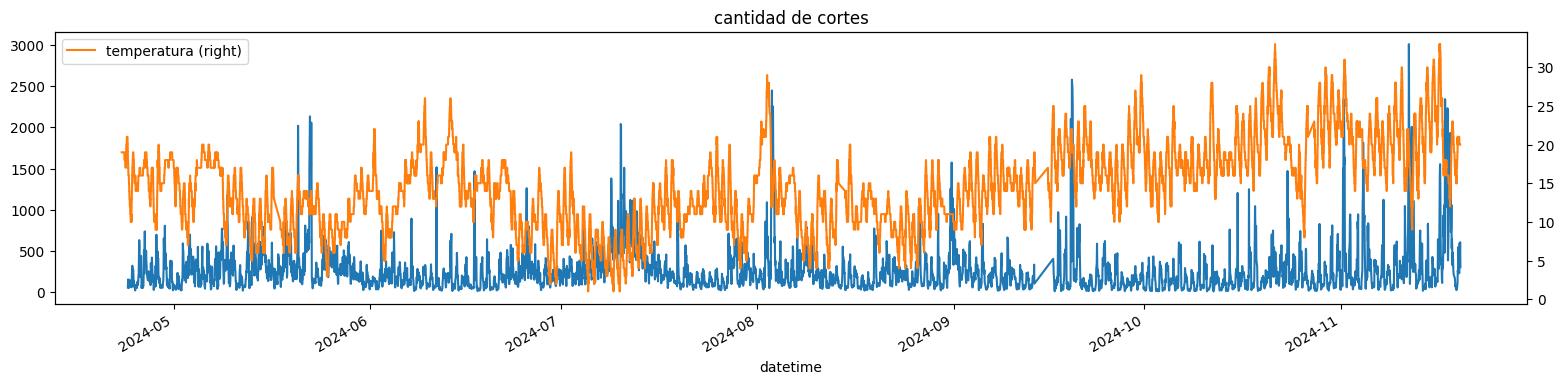

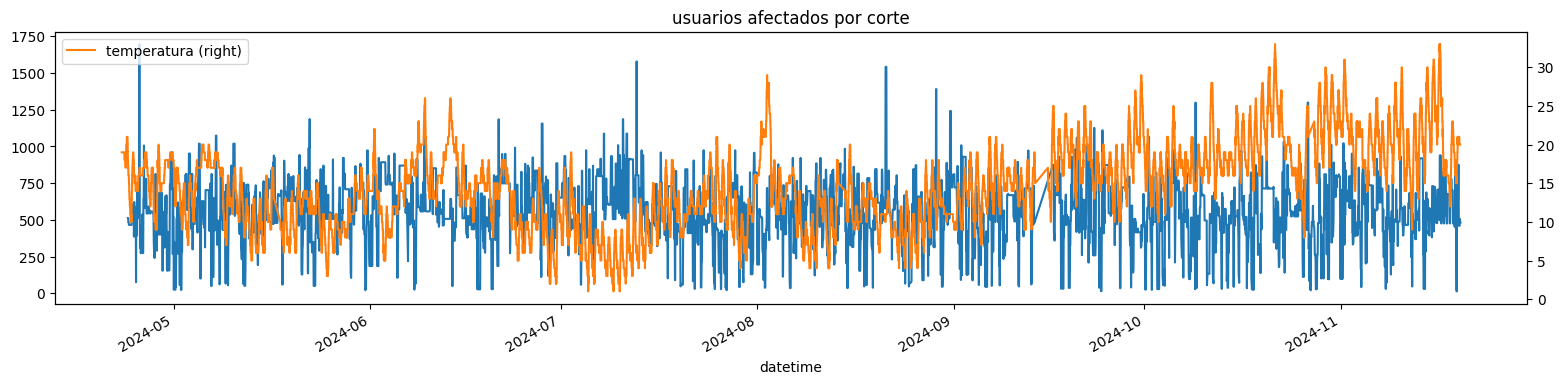

In [194]:
from collections import Counter
import matplotlib.pyplot as plt

plt.figure(figsize=(19,4))

x, y = zip(*sorted(Counter([e['date_hour'] for e in cortes]).items()))
plt.plot(x, y)#, '-o')

# plt.yscale('log')
pd.DataFrame(clima).set_index('datetime').temperatura.apply(int).sort_index().plot(secondary_y=True)
plt.title('cantidad de cortes')
plt.legend()
plt.xticks(rotation=45);

plt.figure(figsize=(19,4))

merged.groupby('date_hour')['usuarios afectados'].max().plot()
# plt.yscale('log')
pd.DataFrame(clima).set_index('datetime').temperatura.apply(int).sort_index().plot(secondary_y=True)

plt.title('usuarios afectados por corte')
plt.legend()
plt.xticks(rotation=45);

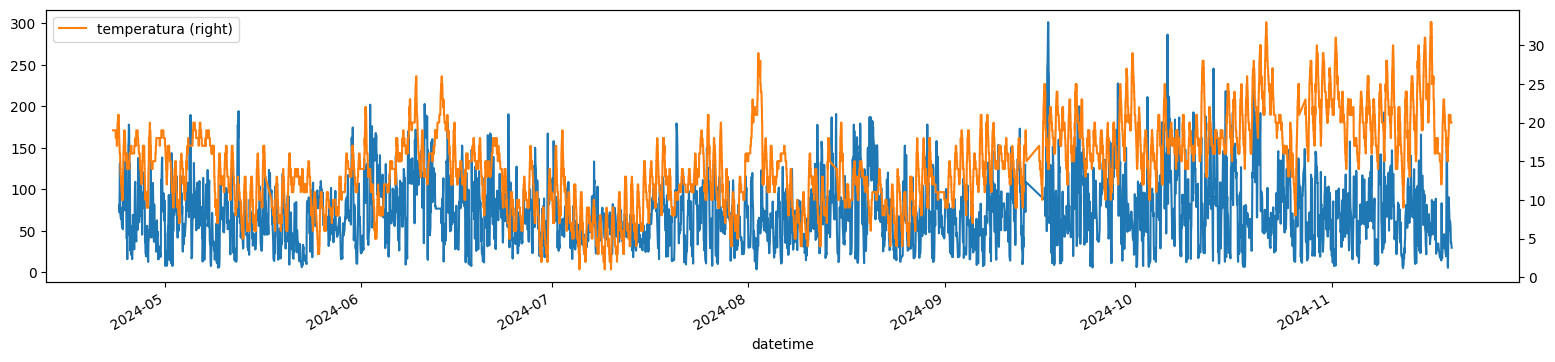

* naranja: temperatura
* azul: cantidad de cortes


In [96]:
len(demanda_df)

118953

In [97]:
region2str = {
    1077: 'EDESUR',  1078: 'EDENOR', 
}

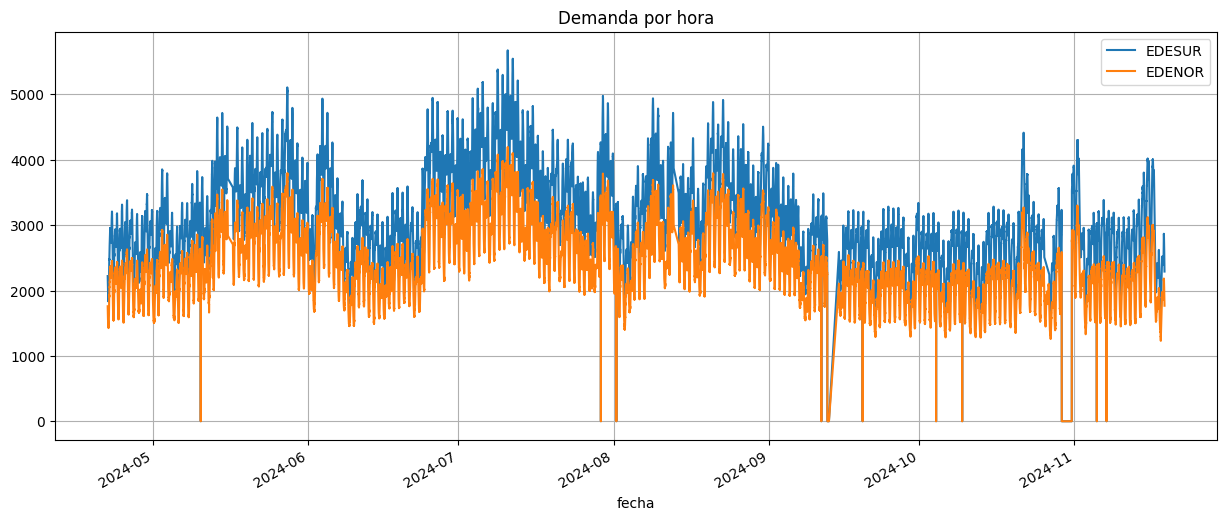

In [205]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

plt.title('Demanda por hora')
for region in demanda_df.region.unique():
    demanda_df[demanda_df.region==region].set_index('fecha').sort_index().dem.plot(label=region2str[region])
    
plt.legend(loc='best')
plt.grid();

In [109]:
cortes_df = pd.DataFrame(cortes)
cortes_df['usuarios afectados'] = cortes_df['usuarios afectados'].apply(int)
cortes_df['region'] = cortes_df.empresa.apply(lambda e: 1077 if e == 'EDESUR S.A.' else 1078)


In [110]:
s = cortes_df.date_hour.sort_values().diff().value_counts()[1:].sort_values()
s

date_hour
0 days 03:00:00       1
2 days 22:00:00       1
0 days 04:00:00       1
0 days 02:00:00     131
0 days 01:00:00    4703
Name: count, dtype: int64

In [111]:
clima_df = pd.DataFrame(clima)
clima_df['date_hour'] = clima_df.datetime.apply(lambda x: x.replace(minute=0))
clima_df['temperatura'] = clima_df['temperatura'].astype('int')

In [112]:
clima_df.head()

,hour,ufs_edesur,ufs_edenor,codigo,estado_cielo,temperatura,datetime,date_hour
0,19:55,504,1007,01n,Cielo Claro,14,2024-09-03 19:55:00,2024-09-03 19:00:00
1,20:00,504,1007,01n,Cielo Claro,15,2024-09-03 20:00:00,2024-09-03 20:00:00
2,20:05,416,229,01n,Cielo Claro,15,2024-09-03 20:05:00,2024-09-03 20:00:00
3,20:10,416,229,01n,Cielo Claro,15,2024-09-03 20:10:00,2024-09-03 20:00:00
4,20:15,416,229,01n,Cielo Claro,15,2024-09-03 20:15:00,2024-09-03 20:00:00


In [113]:
clima_df_hour = (
    clima_df.groupby('date_hour')
            .agg({'estado_cielo': pd.Series.mode, 'ufs_edesur': 'mean', 
                  'ufs_edenor': 'mean', 'temperatura': 'mean'})
           .reset_index()
)

In [114]:
len(clima_df_hour)

4945

In [115]:
clima_df_hour.head()

,date_hour,estado_cielo,ufs_edesur,ufs_edenor,temperatura
0,2024-04-22 20:00:00,Nubes,856.916667,398.500000,19.0
1,2024-04-22 21:00:00,Lluvia Moderada,1452.916667,903.666667,19.0
2,2024-04-22 22:00:00,Nubes,289.833333,1181.416667,19.0
3,2024-04-22 23:00:00,Niebla,243.000000,3806.250000,19.0
4,2024-04-23 00:00:00,Muy Nuboso,2617.000000,2226.250000,19.0


In [220]:
demanda_df['date_hour'] = demanda_df.fecha.apply(lambda x: x.replace(minute=0))
demanda_df_hour = (
    demanda_df[demanda_df.dem>0].groupby(['date_hour', 'region'])
            .agg({'dem': 'mean'})
            .reset_index()
)

In [221]:
merged = (
    cortes_df.merge(clima_df_hour, left_on='date_hour', right_on='date_hour')
             .merge(demanda_df_hour, left_on=('date_hour', 'region'), right_on=('date_hour', 'region'))
)

In [222]:
len(cortes_df), len(clima_df), len(merged)

(1250235, 60480, 1209764)

In [223]:
merged['not_dem'] = merged.dem.isna()
merged.not_dem.sum()

np.int64(0)

In [224]:
(len(cortes_df) - len(merged)) #/ len(cortes_df)

40471

In [225]:
merged = (
    cortes_df.merge(demanda_df_hour, 
                    left_on=('date_hour', 'region'), right_on=('date_hour', 'region'), 
                    how='left')
            .merge(clima_df_hour, 
                    left_on='date_hour', right_on='date_hour',how='left')
)

In [229]:
merged['not_dem'] = merged.dem.isna()
merged.not_dem.sum()

np.int64(28580)

In [230]:
merged['not_dem'] = merged.dem.isna()
merged.not_dem.sum()

np.int64(28580)

<Axes: xlabel='fname_date'>

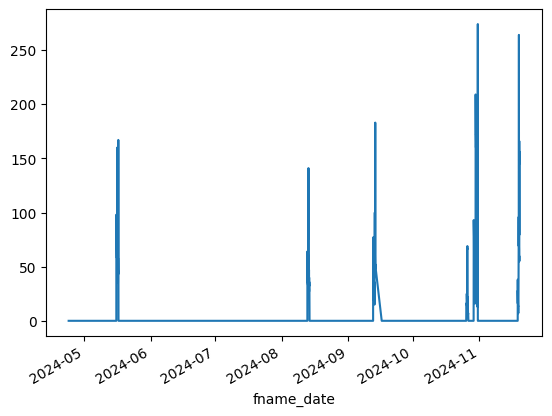

In [231]:

merged.groupby('fname_date').not_dem.sum().plot()

In [232]:
len(cortes_df), len(clima_df), len(merged)

(1250235, 60480, 1250235)

In [233]:
len(cortes_df) - len(merged)

0

In [234]:
merged['not_clima'] = merged.estado_cielo.isna()
merged.not_clima.sum()

np.int64(13014)

In [235]:
merged['not_dem'] = merged.dem.isna()
merged.not_dem.sum()

np.int64(28580)

In [236]:
37787 / len(merged) 

0.030223917903434153

<Axes: xlabel='date_hour'>

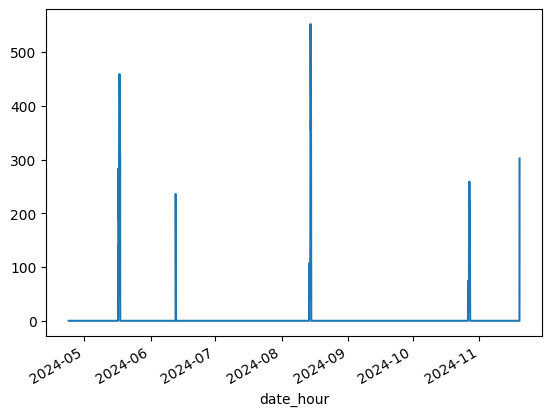

In [237]:
merged.groupby('date_hour').not_clima.sum().plot()

<Axes: xlabel='fname_date'>

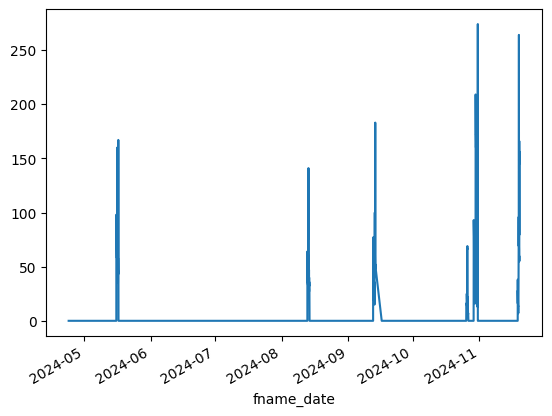

In [238]:
s = merged.groupby('fname_date').not_dem.sum()
s.plot()

In [239]:
demanda_df.head()

,fecha,region,dem,date_hour,hour
0,2024-06-08 00:00:00,1077,2765,2024-06-08,0
1,2024-06-08 00:05:00,1077,2741,2024-06-08,0
2,2024-06-08 00:10:00,1077,2719,2024-06-08,0
3,2024-06-08 00:15:00,1077,2695,2024-06-08,0
4,2024-06-08 00:20:00,1077,2670,2024-06-08,0


In [240]:
demanda_df['hour'] = demanda_df.fecha.apply(lambda x:x.hour)
demanda_df.groupby('hour').dem.count()

hour
0     4965
1     4956
2     4956
3     4956
4     4956
5     4956
6     4956
7     4956
8     4956
9     4956
10    4956
11    4956
12    4956
13    4956
14    4956
15    4956
16    4956
17    4956
18    4956
19    4956
20    4956
21    4956
22    4956
23    4956
Name: dem, dtype: int64

<Axes: xlabel='hour'>

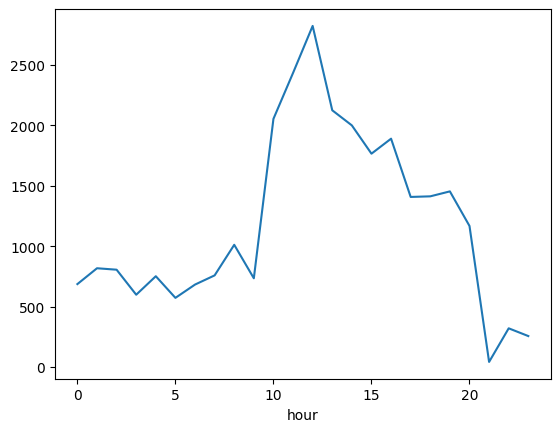

In [241]:
merged['hour'] = merged.fname_date.apply(lambda x: x.hour)
s = merged.groupby('hour').not_dem.sum()
s.plot()

In [242]:
pd.options.display.max_columns = 1000

In [243]:
merged.head()

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,fname_date,date_hour,region,partido_localidad,dem,estado_cielo,ufs_edesur,ufs_edenor,temperatura,not_dem,not_clima,hour
0,-34.630380,-58.463942,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,FLORES GP,ALBERDI,R:218-1-11/218-1-11,138,Sin datos,2024-10-20 04:36:00,2024-10-20 05:00:00,1077,CAPITAL GP/FLORES GP,1870.5,Cielo Claro,4308.25,15.0,19.166667,False,False,4
1,-34.738170,-58.383231,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,LOMAS DE ZAMORA,BANDFIELD,HEROES DE MALVINAS,R:076-1-14/076-1-14,240,2024-10-20 07:17,2024-10-20 04:36:00,2024-10-20 05:00:00,1077,LOMAS DE ZAMORA/BANDFIELD,1870.5,Cielo Claro,4308.25,15.0,19.166667,False,False,4
2,-34.743698,-58.381229,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,LOMAS DE ZAMORA,ZONA RURAL,HEROES DE MALVINAS,R:076-1-14/076-1-14,218,2024-10-20 07:17,2024-10-20 04:36:00,2024-10-20 05:00:00,1077,LOMAS DE ZAMORA/ZONA RURAL,1870.5,Cielo Claro,4308.25,15.0,19.166667,False,False,4
3,-34.743551,-58.385520,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,LOMAS DE ZAMORA,ZONA RURAL,HEROES DE MALVINAS,R:076-1-14/076-1-14,562,2024-10-20 07:17,2024-10-20 04:36:00,2024-10-20 05:00:00,1077,LOMAS DE ZAMORA/ZONA RURAL,1870.5,Cielo Claro,4308.25,15.0,19.166667,False,False,4
4,-34.741728,-58.385022,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,LOMAS DE ZAMORA,ZONA RURAL,HEROES DE MALVINAS,R:076-1-14/076-1-14,465,2024-10-20 07:17,2024-10-20 04:36:00,2024-10-20 05:00:00,1077,LOMAS DE ZAMORA/ZONA RURAL,1870.5,Cielo Claro,4308.25,15.0,19.166667,False,False,4


# Preguntas

1) Sube la demanda cuando aumenta la temperatura?

2) Cuales son las zonas con mas demanda (con la data que tenemos no la podemos contestar)

3) Cuales son las zonas con mas cortes. Coinciden con las de mayor demanda?

4) El estado del cielo correlaciona con la demanda y con los cortes?

5) Hay algun horario de mayor cantidad de cortes?

6) Cuales son las zonas con mas usuarios afectados? 


### 1) Sube la demanda cuando aumenta la temperatura?


In [138]:
merged.fname_date.apply(lambda x: x.hour==10).sum()

np.int64(89633)

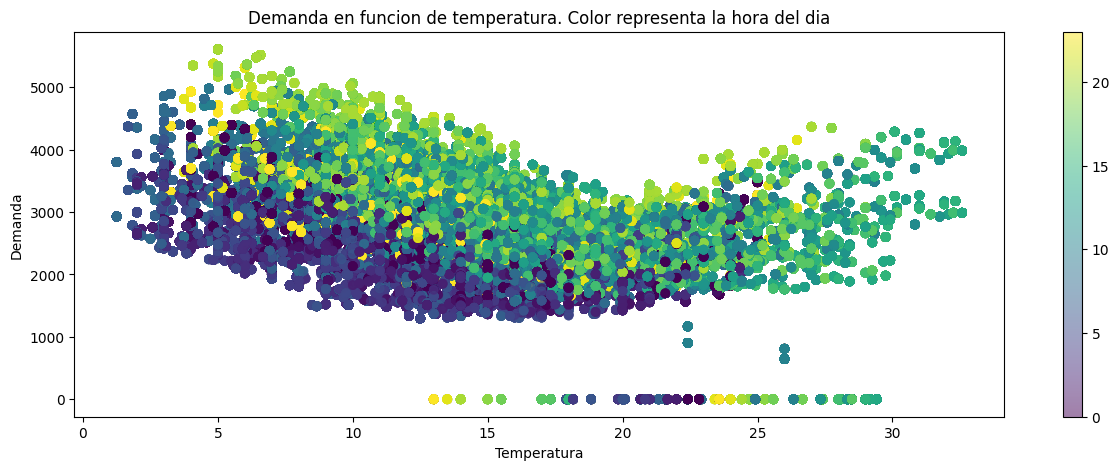

In [156]:
plt.figure(figsize=(15,5))

plt.scatter(merged.temperatura, merged.dem, c=merged.fname_date.apply(lambda x: x.hour), alpha=0.5)
plt.xlabel('Temperatura')
plt.ylabel('Demanda')
plt.title('Demanda en funcion de temperatura. Color representa la hora del dia')
plt.colorbar();

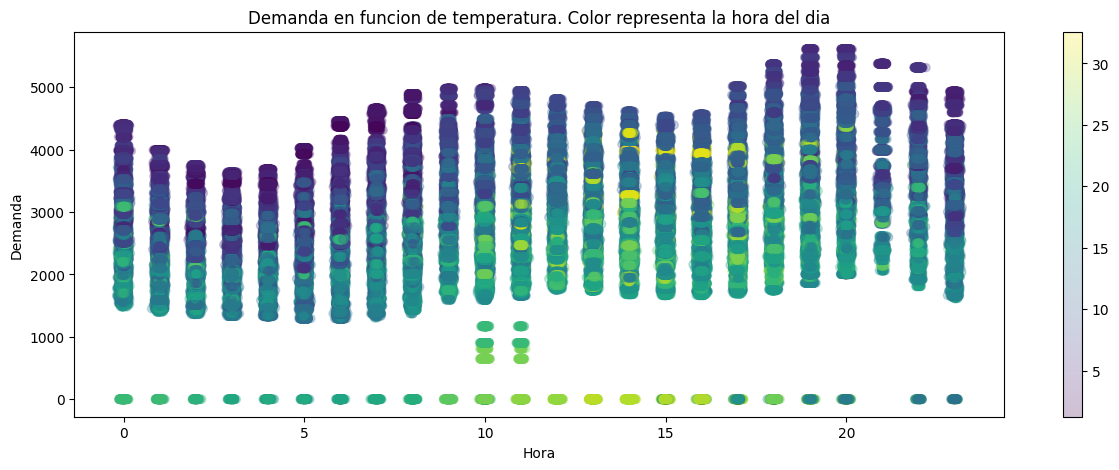

In [140]:
plt.figure(figsize=(15,5))

plt.scatter(merged.fname_date.apply(lambda x: x.hour) + np.random.normal(scale=0.05, size=len(merged)), merged.dem, c=merged.temperatura, alpha=0.25)
plt.xlabel('Hora')
plt.ylabel('Demanda')
plt.title('Demanda en funcion de la hora. Color representa la temperatura')
plt.colorbar();

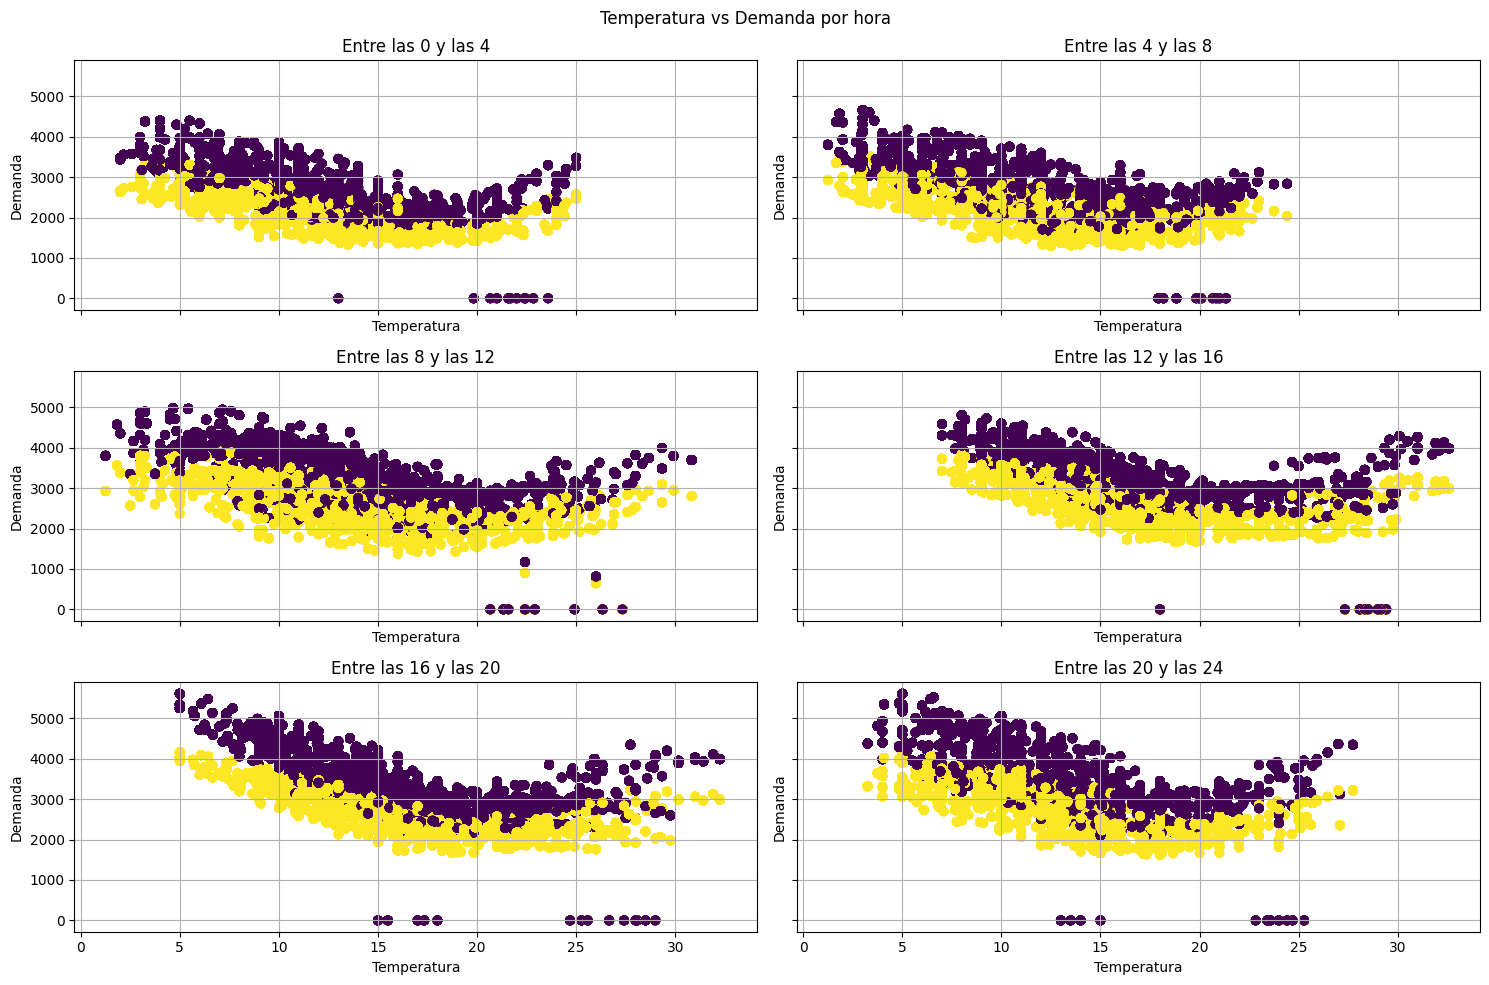

In [155]:
fig, subplots = plt.subplots(3,2,figsize=(15,10), sharex=True, sharey=True)
subplots = subplots.reshape(-1)

for i, lower_h in enumerate(range(0, 24, 4)):
    upper_h = lower_h + 4
    mask = merged.fname_date.apply(lambda x: x.hour>=lower_h and x.hour < upper_h)
    ax = subplots[i]
    ax.scatter(merged[mask].temperatura, merged[mask].dem, c=merged[mask].region)
    ax.set_xlabel('Temperatura')
    ax.set_ylabel('Demanda')
    ax.set_title(f'Entre las {lower_h} y las {upper_h}')
    ax.grid()

plt.suptitle('Temperatura vs Demanda por hora')
plt.tight_layout();

### 3) Cuales son las zonas con mas cortes. Coinciden con las de mayor demanda?


In [142]:
cortes_df['partido_localidad'] = cortes_df.partido + "/" + cortes_df.localidad

In [157]:
cortes_df.partido_localidad.value_counts().head(10)

partido_localidad
SAN FERNANDO/DELTA 2DA SECCION (SF)    87622
TIGRE/DELTA 1RA SECCION (TI)           71953
FLORENCIO VARELA/FLORENCIO VARELA      61183
SAN FERNANDO/DELTA 3RA SECCION (SF)    39872
SAN VICENTE/SAN VICENTE                33838
GRAL RODRIGUEZ/GRAL RODRIGUEZ          27686
ESTEBAN ECHEVERRIA/MONTE GRANDE        18544
PILAR/PILAR                            18488
ESCOBAR/ESCOBAR                        16063
BERAZATEGUI/BERAZATEGUI                15861
Name: count, dtype: int64

### 4) El estado del cielo correlaciona con la demanda y con los cortes?


In [158]:
clima_df['month'] = clima_df.datetime.apply(lambda x: x.month)

In [159]:
clima_df.groupby('month').temperatura.agg(['mean', 'count', 'std', 'min', 'max'])

,mean,count,std,min,max
month,,,,,
4,16.134836,2351,2.650111,9,21
5,12.160185,8640,3.588871,3,20
6,13.625883,8639,4.468211,2,26
7,9.915883,8928,3.995234,1,21
8,11.870647,8643,4.214639,4,29
9,16.390970,8062,3.862570,7,29
10,19.590125,9215,4.354401,8,33
11,20.408364,6002,4.424073,9,33


In [160]:
clima_df.estado_cielo.value_counts()

estado_cielo
Cielo Claro                     29303
Nubes                           11007
Muy Nuboso                       5810
Nubes Dispersas                  4117
Algo De Nubes                    4017
Niebla                           1740
Lluvia Ligera                    1511
Llovizna Ligera                  1015
Lluvia Moderada                   815
Bruma                             536
Llovizna                          300
Lluvia De Gran Intensidad          75
Tormenta Con Lluvia Ligera         74
Tormenta                           56
Tormenta Con Lluvia                45
Tormenta Con Lluvia Intensa        31
Llovizna De Gran Intensidad        21
Lluvia Y Llovizna                   4
Humo                                3
Name: count, dtype: int64

([<matplotlib.axis.XTick at 0x12cafb350>], [Text(1, 0, 'dem')])

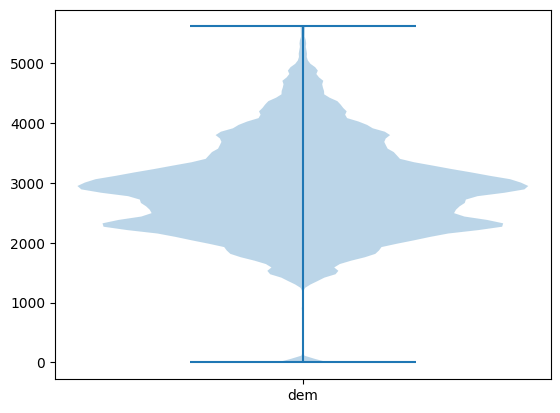

In [147]:
plt.violinplot(merged.dem.dropna())
plt.xticks([1], ['dem'])

In [148]:
temp_merged = merged.dropna(subset=['temperatura']).copy()

([<matplotlib.axis.XTick at 0x12ca10590>], [Text(1, 0, 'usuarios afectados')])

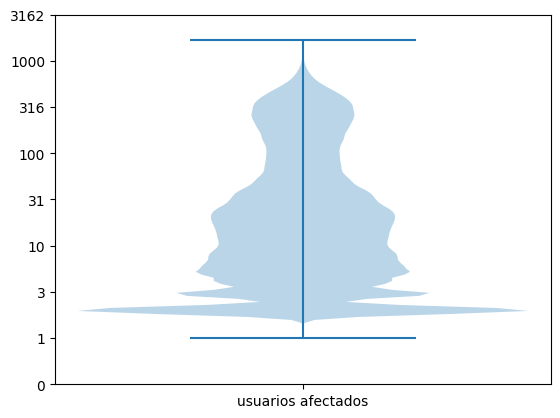

In [149]:
import numpy as np

plt.violinplot(np.log10(merged['usuarios afectados'] + 1))
plt.yticks(plt.yticks()[0], [int(e) for e in 10**plt.yticks()[0]])
plt.xticks([1], ['usuarios afectados'])

([<matplotlib.axis.XTick at 0x12c9a2210>], [Text(1, 0, 'usuarios afectados')])

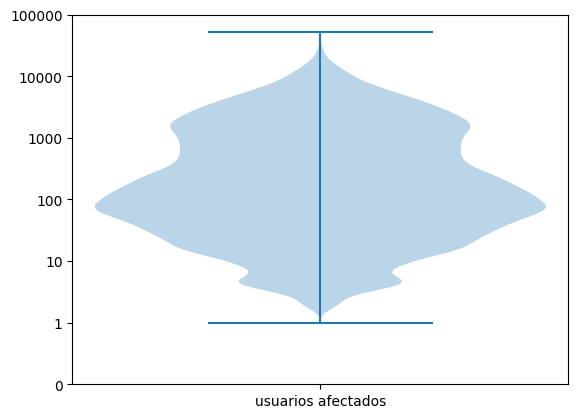

In [150]:
u = merged.groupby(['partido', 'date_hour'])['usuarios afectados'].sum()
plt.violinplot(np.log10(u + 1))
plt.yticks(plt.yticks()[0], [int(e) for e in 10**plt.yticks()[0]])
plt.xticks([1], ['usuarios afectados'])

In [245]:
merged['binned_temperature'] = merged.temperatura.apply(lambda x: int(round(x, 0))//5*5 if not np.isnan(x) else x )

In [246]:
clima_df['binned_temperature'] = clima_df.temperatura.apply(lambda x: int(round(x, 0))//5*5 if not np.isnan(x) else x )

In [247]:
clima_df.binned_temperature.value_counts()

binned_temperature
10    19746
15    19494
5      9274
20     8040
25     2278
0      1239
30      409
Name: count, dtype: int64

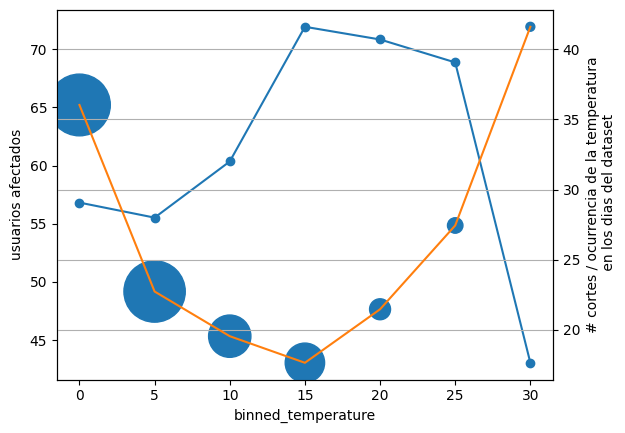

In [248]:
# plt.figure(figsize=(15,4))

# plt.subplot(121)
g = merged.groupby('binned_temperature')['usuarios afectados']
g.mean().sort_index().plot(marker='o')


plt.ylabel('usuarios afectados')
plt.xlabel('temperatura')

bin_temp_freq = clima_df.binned_temperature.value_counts()
ratio = (g.count() / bin_temp_freq).sort_index()


ax = ratio.plot(secondary_y=True, )
ax.scatter(ratio.index, ratio.values, s=bin_temp_freq.values/10)

# (g.count() / clima_df.binned_temperature.value_counts()).sort_index().plot(secondary_y=True, marker='o')

plt.ylabel('# cortes / ocurrencia de la temperatura\n en los dias del dataset')
plt.grid()

# plt.subplot(122)
# clima_df.binned_temperature.value_counts().sort_index().plot()
# plt.title('frecuencia de binned_temperature')
# plt.grid()
# ;

Naranja = # cortes / ocurrencia de la temperatura en los dias del dataset
Azul: Cantidad de usuarios afectados por corte



Interpretación: son pocos cortes los que ocurrieron cuando la temperatura era 30 grados (porque tenemos pocos datos de 30 grados). Son datos de julio en adelante

In [249]:
demanda_df

,fecha,region,dem,date_hour,hour
0,2024-06-08 00:00:00,1077,2765,2024-06-08 00:00:00,0
1,2024-06-08 00:05:00,1077,2741,2024-06-08 00:00:00,0
2,2024-06-08 00:10:00,1077,2719,2024-06-08 00:00:00,0
3,2024-06-08 00:15:00,1077,2695,2024-06-08 00:00:00,0
4,2024-06-08 00:20:00,1077,2670,2024-06-08 00:00:00,0
...,...,...,...,...,...
121663,2024-08-01 23:35:00,1077,2674,2024-08-01 23:00:00,23
121664,2024-08-01 23:40:00,1077,2656,2024-08-01 23:00:00,23
121665,2024-08-01 23:45:00,1077,2639,2024-08-01 23:00:00,23
121666,2024-08-01 23:50:00,1077,2615,2024-08-01 23:00:00,23


In [218]:
demanda_df.dem[demanda_df.dem>0].min()

np.int64(1230)

In [252]:
merged['binnedDemanda'] = merged.dem.apply(lambda x: int(round(x, 0))//100*100 if not np.isnan(x) else x )

Text(0.5, 0, 'demanda')

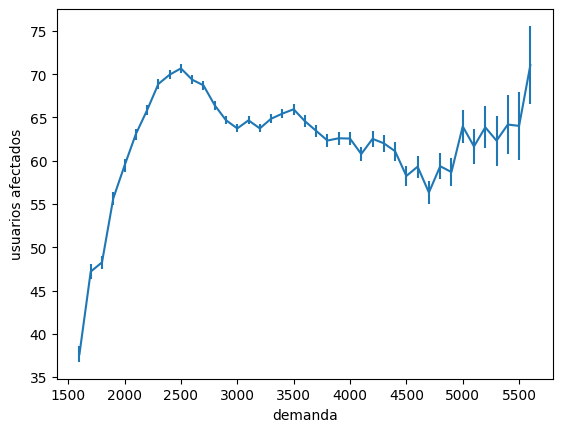

In [254]:
g = merged[merged.dem > 0].groupby('binnedDemanda')['usuarios afectados']
mean = g.mean().sort_index().rolling(5).mean().dropna()
std = g.std().sort_index().rolling(5).mean().dropna() / (g.count().sort_index().rolling(5).mean().dropna())**0.5


plt.errorbar(mean.index, mean.values, yerr=std.values)
plt.ylabel('usuarios afectados')
plt.xlabel('demanda')

Text(0.5, 0, 'demanda')

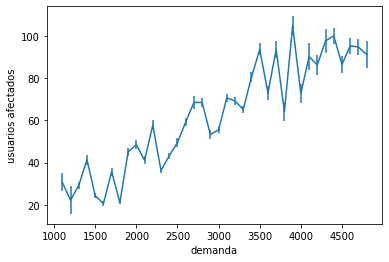

In [226]:
g = merged[~merged.demHoy.isna()].groupby('binnedDemanda')['usuarios afectados']
mean = g.mean().sort_index().dropna()
std = g.std().sort_index().dropna() / (g.count().sort_index().dropna())**0.5


plt.errorbar(mean.index, mean.values, yerr=std.values)
plt.ylabel('usuarios afectados')
plt.xlabel('demanda')

In [229]:
merged.to_csv('a.csv')
a = pd.read_csv('a.csv')

In [235]:
clima_df.head()

,hour,ufs_edesur,ufs_edenor,codigo,estado_cielo,temperatura,datetime,date_hour
0,01:20,41164,1969,01n,Cielo Claro,26,2024-02-11 01:20:00,2024-02-11 01:00:00
1,01:25,41164,1969,01n,Cielo Claro,26,2024-02-11 01:25:00,2024-02-11 01:00:00
2,01:30,38574,1969,01n,Cielo Claro,26,2024-02-11 01:30:00,2024-02-11 01:00:00
3,01:35,38574,1969,01n,Cielo Claro,25,2024-02-11 01:35:00,2024-02-11 01:00:00
4,01:40,38574,1969,01n,Cielo Claro,25,2024-02-11 01:40:00,2024-02-11 01:00:00


<AxesSubplot:xlabel='temperatura'>

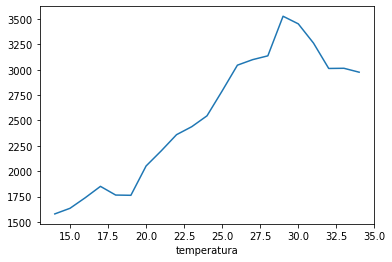

In [240]:
clima_df.merge(demanda_df, on='date_hour').groupby('temperatura').demHoy.mean().sort_index().plot()

In [239]:
clima_df.merge(demanda_df, on='date_hour').groupby('estado_cielo').demHoy.mean().sort_values(ascending=False)

estado_cielo
Nubes                           3080.761733
Algo De Nubes                   2927.881699
Nubes Dispersas                 2847.139645
Muy Nuboso                      2759.567203
Cielo Claro                     2686.762961
Lluvia De Gran Intensidad       2490.611538
Lluvia Ligera                   2465.537234
Lluvia Moderada                 2454.179167
Tormenta Con Lluvia Ligera      2068.166667
Tormenta Con Lluvia Intensa     2032.583333
Tormenta Con Lluvia             2032.557087
Name: demHoy, dtype: float64

In [243]:
clima_df.groupby('estado_cielo').temperatura.mean().sort_values(ascending=False)

estado_cielo
Algo De Nubes                   28.055339
Nubes Dispersas                 27.064066
Cielo Claro                     26.048100
Muy Nuboso                      25.470725
Nubes                           24.700000
Lluvia Ligera                   24.647287
Lluvia Moderada                 23.688581
Tormenta Con Lluvia Ligera      22.000000
Lluvia De Gran Intensidad       21.028571
Tormenta Con Lluvia             20.288889
Tormenta Con Lluvia Intensa     20.000000
Name: temperatura, dtype: float64

In [ ]:
clima_df.merge(demanda_df, on='date_hour').groupby('estado_cielo').demHoy.mean().sort_values(ascending=False)

In [230]:
(
    a[~merged.demHoy.isna()].groupby('estado_cielo')
          .agg({'region': 'count', 'demHoy': 'mean'})
          .rename(columns=dict(region='cortes'))
          .sort_values('cortes', ascending=False)
)

,cortes,demHoy
estado_cielo,,
Cielo Claro,38723,2933.123636
Algo De Nubes,15892,2851.188700
Muy Nuboso,14776,2622.964800
Nubes Dispersas,14446,2753.606251
Nubes,9525,3293.536658
['Cielo Claro ' 'Nubes '],567,3741.761317
Lluvia Moderada,273,3162.240842
['Lluvia Moderada ' 'Nubes Dispersas '],242,3153.477961
Lluvia Ligera,124,2258.887097


In [109]:
plt.scatter(merged)

<module 'matplotlib.pyplot' from '/Users/przivic/miniconda3/envs/mlp2022/lib/python3.9/site-packages/matplotlib/pyplot.py'>

In [ ]:
demanda_df, cortes_df, clima_df

In [105]:
cortes_df.groupby('alimentador').latitud.nunique()

alimentador
N:                                           76
N:089-1-14/089-1-14                           1
N:SAN JUSTO/164-TR1/164-5518                  1
R:                                           97
R:020-4-45/020-4-45                           1
R:022-1-15/022-1-15                           1
R:023-1-14/023-1-14                           4
R:073-4-46/073-4-46                           1
R:077-3-34/077-3-34                          12
R:079-5-54/079-5-54                           5
R:089-1-16/089-1-16                           1
R:113-1-17/113-1-17                           8
R:122-4-41/122-4-41                           5
R:122-4-43/122-4-43                          12
R:122-4-45/122-4-45                           2
R:122-4-47/122-4-47                           8
R:143-3-36/143-3-36                           3
R:147-2-22/147-2-22                           1
R:172-2-26/172-2-26                           6
R:179-2-22/179-2-22                           1
R:182-1-16/182-1-16         

In [87]:
cortes_df.sample(10)

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,date_hour,region
8714,-34.624256,-59.044691,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,GRAL RODRIGUEZ,GRAL RODRIGUEZ,S/D,R:MALVINAS/169-TR2/169-5476/255-5521,5,2024-02-12 01:00,2024-02-11 22:00:00,1078
2473,-34.767300,-58.221500,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,BERAZATEGUI,BERAZATEGUI,NaN,NaN,69,NaN,2024-02-11 07:00:00,1077
7210,-34.289506,-58.586989,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,TIGRE,DELTA 1RA SECCION (TI),S/D,R:TIGRE/153-TR2/153-5526,12,Sin datos,2024-02-11 09:00:00,1078
9136,-34.628725,-58.436919,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,PARQUE CHACABUCO,S/D,R:,21,Sin datos,2024-02-12 01:00:00,1077
5626,-34.626183,-58.445645,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,CABALLITO RP,ALBERDI,N:218-3-32/218-3-32,22,2024-02-12 13:58,2024-02-12 12:00:00,1077
1092,-34.614974,-58.432988,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,478,2024-02-11 14:54,2024-02-11 02:00:00,1077
5944,-34.611786,-58.444079,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,606,Sin datos,2024-02-11 23:00:00,1077
2645,-35.064371,-58.545159,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,SAN VICENTE,SAN VICENTE,GLEW,R:277-4-44/277-4-44/271-4-81,1,2024-02-11 14:41,2024-02-11 13:00:00,1077
9642,-34.852165,-58.259581,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,FLORENCIO VARELA,FLORENCIO VARELA,BOSQUES,R:185-2-25/185-2-25,5,2024-02-11 21:11,2024-02-11 14:00:00,1077
7036,-34.711000,-58.429800,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,LANUS,LANUS,NaN,NaN,21,NaN,2024-02-12 07:00:00,1077


In [38]:
cortes_df.groupby('alimentador').latitud.count().sort_values(ascending=False)

alimentador
R:TIGRE/153-TR2/153-5526           5276
R:15-2521                          4727
R:                                 2531
N:                                 2084
R:185-1-16/185-1-16                2067
                                   ... 
R:TORTUGUITAS/252-TR2/252-5534        1
R:FORD/151-TR2/151-5531               1
R:ALTOS/272-TR2/272-5533              1
R:ARA SAN JUAN/362-TR2/362-5525       1
R:SAN JUSTO/164-TR1/164-5512          1
Name: latitud, Length: 454, dtype: int64

In [87]:
cortes_df.sample(10)

,latitud,longitud,misc,descr,tipo,empresa,partido,localidad,subestacion,alimentador,usuarios afectados,hora estimada de normalizacion,date_hour,region
8714,-34.624256,-59.044691,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,GRAL RODRIGUEZ,GRAL RODRIGUEZ,S/D,R:MALVINAS/169-TR2/169-5476/255-5521,5,2024-02-12 01:00,2024-02-11 22:00:00,1078
2473,-34.767300,-58.221500,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,BERAZATEGUI,BERAZATEGUI,NaN,NaN,69,NaN,2024-02-11 07:00:00,1077
7210,-34.289506,-58.586989,12,"<b>CORTE DE MEDIA TENSION</b>, EDENOR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDENOR S.A.,TIGRE,DELTA 1RA SECCION (TI),S/D,R:TIGRE/153-TR2/153-5526,12,Sin datos,2024-02-11 09:00:00,1078
9136,-34.628725,-58.436919,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,PARQUE CHACABUCO,S/D,R:,21,Sin datos,2024-02-12 01:00:00,1077
5626,-34.626183,-58.445645,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL RP,CABALLITO RP,ALBERDI,N:218-3-32/218-3-32,22,2024-02-12 13:58,2024-02-12 12:00:00,1077
1092,-34.614974,-58.432988,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,478,2024-02-11 14:54,2024-02-11 02:00:00,1077
5944,-34.611786,-58.444079,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,CAPITAL GP,CABALLITO GP,S/D,R:,606,Sin datos,2024-02-11 23:00:00,1077
2645,-35.064371,-58.545159,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,SAN VICENTE,SAN VICENTE,GLEW,R:277-4-44/277-4-44/271-4-81,1,2024-02-11 14:41,2024-02-11 13:00:00,1077
9642,-34.852165,-58.259581,11,"<b>CORTE DE MEDIA TENSION</b>, EDESUR S.A., Pa...",<b>CORTE DE MEDIA TENSION</b>,EDESUR S.A.,FLORENCIO VARELA,FLORENCIO VARELA,BOSQUES,R:185-2-25/185-2-25,5,2024-02-11 21:11,2024-02-11 14:00:00,1077
7036,-34.711000,-58.429800,21,"<b>CORTE DE BAJA TENSION</b>, EDESUR S.A., Par...",<b>CORTE DE BAJA TENSION</b>,EDESUR S.A.,LANUS,LANUS,NaN,NaN,21,NaN,2024-02-12 07:00:00,1077


# ni idea

In [287]:
c1 = {e['datetime']: e  for e in parse_clima('data/clima-enre-2024-03-10T20:10.txt.gz')}

In [288]:
c2 = {e['datetime']: e  for e in parse_clima('data/clima-enre-2024-03-10T21:50.txt.gz')}

In [292]:
inters = list(set(c1).intersection(c2))

for dt in inters:
    if c1[dt] != c2[dt]: 1/0

In [286]:
c1

[{'hour': '21:40',
  'ufs_edesur': 4354,
  'ufs_edenor': 7250,
  'codigo': '01n',
  'estado_cielo': 'Cielo Claro ',
  'temperatura': '26',
  'datetime': datetime.datetime(2024, 3, 9, 21, 40)},
 {'hour': '21:45',
  'ufs_edesur': 4354,
  'ufs_edenor': 7250,
  'codigo': '01n',
  'estado_cielo': 'Cielo Claro ',
  'temperatura': '26',
  'datetime': datetime.datetime(2024, 3, 9, 21, 45)},
 {'hour': '21:50',
  'ufs_edesur': 4354,
  'ufs_edenor': 7250,
  'codigo': '01n',
  'estado_cielo': 'Cielo Claro ',
  'temperatura': '26',
  'datetime': datetime.datetime(2024, 3, 9, 21, 50)},
 {'hour': '21:55',
  'ufs_edesur': 7869,
  'ufs_edenor': 954,
  'codigo': '01n',
  'estado_cielo': 'Cielo Claro ',
  'temperatura': '26',
  'datetime': datetime.datetime(2024, 3, 9, 21, 55)},
 {'hour': '22:00',
  'ufs_edesur': 7869,
  'ufs_edenor': 954,
  'codigo': '01n',
  'estado_cielo': 'Cielo Claro ',
  'temperatura': '26',
  'datetime': datetime.datetime(2024, 3, 9, 22, 0)},
 {'hour': '22:05',
  'ufs_edesur': 786

In [277]:
!ls data | grep clim

clima-enre-2024-02-11T13.txt
clima-enre-2024-02-11T13.txt.gz
clima-enre-2024-02-11T14.txt.gz
clima-enre-2024-02-11T15.txt.gz
clima-enre-2024-02-11T16.txt.gz
clima-enre-2024-02-11T17.txt.gz
clima-enre-2024-02-11T18.txt.gz
clima-enre-2024-02-11T19.txt.gz
clima-enre-2024-02-11T20.txt.gz
clima-enre-2024-02-11T22.txt.gz
clima-enre-2024-02-11T23.txt.gz
clima-enre-2024-02-12T00.txt.gz
clima-enre-2024-02-12T01.txt.gz
clima-enre-2024-02-12T02.txt.gz
clima-enre-2024-02-12T03.txt.gz
clima-enre-2024-02-12T04.txt.gz
clima-enre-2024-02-12T05.txt.gz
clima-enre-2024-02-12T06.txt.gz
clima-enre-2024-02-12T07.txt.gz
clima-enre-2024-02-12T08.txt.gz
clima-enre-2024-02-12T09.txt.gz
clima-enre-2024-02-12T10.txt.gz
clima-enre-2024-02-12T11.txt.gz
clima-enre-2024-02-12T12.txt.gz
clima-enre-2024-02-12T13.txt.gz
clima-enre-2024-02-12T14.txt.gz
clima-enre-2024-02-12T15:09.txt.gz
clima-enre-2024-02-12T15:30.txt.gz
clima-enre-2024-02-12T20:11.txt.gz
clima-enre-2024-02-12T21:50.txt.gz
clima-enre-2024-02-13T20:10.txt

In [233]:
demanda_df.fecha.sort_values().diff().value_counts()

0 days 00:00:00    9506
0 days 00:05:00    9504
1 days 00:00:00       1
Name: fecha, dtype: int64

# Algoritmo duracion cortes

In [92]:
cortes_df.subestacion.isna().sum() / len(cortes_df)

0.24566469785328013

In [20]:
for c in cortes:
    if 'subestacion' in c:
        c['id'] = c['subestacion']
    else:
        c['id'] = c['localidad']

In [134]:
from itertools import groupby

# Algoritmo de Maru :heart:
cortes.sort(key=lambda x: (x['id'], x['date_hour']))

for id, id_cortes in groupby(cortes, key=lambda x: x['id']):
    last_hour = None
    current = []
    id_cortes = list(id_cortes)
    import ipdb;ipdb.set_trace()
    for corte in id_cortes:
        if last_hour is None:
            last_hour = corte['date_hour']
            current.append(corte)
            
        elif (corte['date_hour'] - last_hour).total_seconds() <= 30*60:
            last_hour = corte['date_hour']
            current.append(corte)
            
        else:
            duration = current[-1]['date_hour'] - current[0]['date_hour']
            for c in current:
                c['real_duration'] = duration
                
            current = [corte]
    
    if current:
        duration = current[-1]['date_hour'] - current[0]['date_hour']
        for c in current:
            c['real_duration'] = duration

    
    

> /var/folders/55/555sz06s5477c_l2bss1ndnwmmmmq7/T/ipykernel_4502/2065986696.py(11)<cell line: 6>()
     10     import ipdb;ipdb.set_trace()
---> 11     for corte in id_cortes:
     12         if last_hour is None:

ipdb> q


BdbQuit: 

In [21]:
import folium
from folium.plugins import HeatMap

# Create a base map using OpenStreetMap

m = folium.Map(location=[cortes_df.latitud.median(), cortes_df.longitud.median()], zoom_start=12)

# Sample data points (replace with your own data)
# data_points = [(latitude1, longitude1), (latitude2, longitude2), ...]
data_points = []
for doc in cortes_df.groupby(['latitud', 'longitud']):
    data_points.append((doc['latitud'], doc['longitud'], int(doc['usuarios afectados'])))

# Add a heatmap layer
HeatMap(data_points, radius=20).add_to(m)

# OR
m

TypeError: tuple indices must be integers or slices, not str